# Multi-Head Latent Attention (MLA): Theory and Implementation

Welcome to this comprehensive notebook on **Multi-Head Latent Attention (MLA)**, a revolutionary attention mechanism introduced by DeepSeek that significantly reduces KV cache memory requirements while maintaining performance.

## 🎯 Learning Objectives
By the end of this notebook, you will understand:
- The motivation and mathematical foundation of MLA
- The "absorption trick" that enables efficient caching
- Step-by-step matrix operations with exact dimensions
- Complete PyTorch implementation from scratch
- Memory savings and performance characteristics

## 🔑 Key Concepts
- **Latent Space Projection**: Input embeddings are projected to a lower-dimensional latent space
- **Single Cache**: Only one latent matrix is cached instead of separate keys and values
- **Absorption Trick**: WQ and WUK matrices are merged to enable efficient computation
- **Head Diversity**: Each head maintains unique projections (no sharing like in MQA/GQA)

## 📊 Example Setup
Throughout this notebook, we'll use these dimensions:
- **d_model** = 8 (embedding dimension)
- **d_latent** = 4 (latent dimension) 
- **n_heads** = 2 (number of attention heads)
- **d_head** = d_model / n_heads = 4

Let's dive into the mathematical foundations!

## 📐 Mathematical Foundation of MLA

### Standard Multi-Head Attention vs MLA
In standard MHA, we cache separate key and value matrices for each head:
- **Cache Size**: `2 × n_heads × d_head × seq_len` (keys + values)

In MLA, we cache only one latent matrix:
- **Cache Size**: `d_latent × seq_len` (latent matrix only)

### Weight Matrices in MLA

| Matrix | Shape | Description |
|--------|-------|-------------|
| **WQ** | `[d_model, d_model]` | Query projection matrix |
| **W_DKV** | `[d_model, d_latent]` | Down-projection to latent space |
| **W_UK** | `[d_latent, d_model]` | Key up-projection from latent space |
| **W_UV** | `[d_latent, d_model]` | Value up-projection from latent space |
| **WO** | `[d_model, d_model]` | Output projection matrix |

### The Absorption Trick 🔥

The key insight is that we can merge matrices:
```
Q = X @ WQ
K = (X @ W_DKV) @ W_UK = X @ (W_DKV @ W_UK)
```

By pre-computing `W_QK = WQ @ W_UK.T`, we get:
```
Attention_Scores = (X @ W_QK) @ (X @ W_DKV).T
```

This means we only need to cache `C_KV = X @ W_DKV` (the latent matrix)!

### Memory Savings Example
- **DeepSeek-V2**: Uses d_latent=576 vs d_model=5120
- **Reduction**: ~57× smaller KV cache compared to standard MHA
- **Performance**: Maintains full model performance (no head sharing)

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Optional, Tuple

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully!
PyTorch version: 2.6.0+cpu
Device: CPU


In [6]:
class RolesMLA(nn.Module):
    """
    Multi-Head Latent Attention (MLA) implementation.
    
    Key Features:
    - Projects input to latent space for KV cache efficiency
    - Uses absorption trick to merge WQ and W_UK matrices
    - Maintains head diversity (no parameter sharing)
    - Significant memory savings during inference
    """
    
    def __init__(self, d_model: int = 8, d_latent: int = 4, n_heads: int = 2):
        super().__init__()
        
        # Model dimensions
        self.d_model = d_model      # 8 - embedding dimension
        self.d_latent = d_latent    # 4 - latent dimension  
        self.n_heads = n_heads      # 2 - number of heads
        self.d_head = d_model // n_heads  # 4 - dimension per head
        
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        # Weight matrices (all without bias for efficiency)
        self.WQ = nn.Linear(d_model, d_model, bias=False)     # [8, 8] - Query projection
        self.W_DKV = nn.Linear(d_model, d_latent, bias=False) # [8, 4] - Down-projection to latent
        self.W_UK = nn.Linear(d_latent, d_model, bias=False)  # [4, 8] - Key up-projection  
        self.W_UV = nn.Linear(d_latent, d_model, bias=False)  # [4, 8] - Value up-projection
        self.WO = nn.Linear(d_model, d_model, bias=False)     # [8, 8] - Output projection
        
        # Layer normalization for latent vectors
        self.ln = nn.LayerNorm(d_latent)
        
        print(f"🔧 MLA initialized with:")
        print(f"   d_model={d_model}, d_latent={d_latent}, n_heads={n_heads}")
        print(f"   d_head={self.d_head}")
        print(f"   Memory reduction factor: {(2 * n_heads * self.d_head) / d_latent:.1f}x")
    
    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass for MLA.
        
        Args:
            x: Input token [d_model] or batch [batch, seq_len, d_model]
            kv_cache: Previous latent cache [seq_len, d_latent] or None
            
        Returns:
            output: Context vector [1, d_model] 
            updated_cache: Updated latent cache [seq_len+1, d_latent]
        """
        
        # Handle single token input (inference case)
        if x.dim() == 1:
            x = x.unsqueeze(0).unsqueeze(0)  # [d_model] -> [1, 1, d_model]
        elif x.dim() == 2:
            x = x.unsqueeze(0)  # [seq_len, d_model] -> [1, seq_len, d_model]
        
        batch_size, seq_len, _ = x.shape
        
        print(f"\n🔄 Forward pass:")
        print(f"   Input shape: {x.shape}")
        
        # STEP 1: Compute absorbed query matrix W_QK = WQ @ W_UK
        # This is the key insight - we merge WQ and W_UK matrices!
        # WQ.weight: [8, 8], W_UK.weight: [8, 4] -> W_QK: [8, 4]
        W_QK = torch.matmul(self.WQ.weight, self.W_UK.weight)  # [8, 4]
        print(f"   W_QK (absorbed) shape: {W_QK.shape}")
        
        # STEP 2: Split absorbed matrix by heads 
        # [8, 4] -> [2, 4, 4] (n_heads, d_head, d_latent)
        W_QK_heads = W_QK.view(self.n_heads, self.d_head, self.d_latent)
        print(f"   W_QK_heads shape: {W_QK_heads.shape}")
        
        # STEP 3: Process each token in the sequence
        outputs = []
        current_cache = kv_cache
        
        for i in range(seq_len):
            token = x[:, i, :]  # [batch, d_model] -> [1, 8]
            
            # Split input token by heads
            token_heads = token.view(batch_size, self.n_heads, self.d_head)  # [1, 2, 4]
            
            # Compute absorbed query for each head
            q_absorbed = torch.einsum('bnh,nhd->bnd', token_heads, W_QK_heads)  # [1, 2, 4]
            print(f"   Token {i} - q_absorbed shape: {q_absorbed.shape}")
            
            # STEP 4: Compute new latent KV vector
            new_kv = self.ln(self.W_DKV(token))  # [1, 8] -> [1, 4]
            print(f"   Token {i} - new_kv shape: {new_kv.shape}")
            
            # STEP 5: Update KV cache
            if current_cache is None:
                current_cache = new_kv  # [1, 4]
            else:
                current_cache = torch.cat([current_cache, new_kv], dim=0)  # [seq_len+1, 4]
            
            print(f"   Token {i} - cache shape: {current_cache.shape}")
            
            # STEP 6: Compute attention scores for each head
            # q_absorbed: [1, 2, 4], cache.T: [4, seq_len+1]
            attn_scores = torch.einsum('bnd,dt->bnt', q_absorbed, current_cache.T)  # [1, 2, seq_len+1]
            print(f"   Token {i} - attention scores shape: {attn_scores.shape}")
            
            # STEP 7: Scale and apply softmax
            attn_weights = F.softmax(attn_scores / (self.d_head ** 0.5), dim=-1)  # [1, 2, seq_len+1]
            
            # STEP 8: Compute values and split by heads
            values = self.W_UV(current_cache)  # [seq_len+1, 8]
            values_heads = values.view(-1, self.n_heads, self.d_head)  # [seq_len+1, 2, 4]
            
            # STEP 9: Compute context vectors for each head
            context_heads = torch.einsum('bnt,tnh->bnh', attn_weights, values_heads)  # [1, 2, 4]
            
            # STEP 10: Concatenate heads and apply output projection
            context = context_heads.view(batch_size, self.d_model)  # [1, 8]
            output = self.WO(context)  # [1, 8]
            
            outputs.append(output)
        
        # Return last output and updated cache
        final_output = outputs[-1] if outputs else torch.zeros(batch_size, self.d_model)
        return final_output, current_cache

# Create MLA instance
mla = RolesMLA(d_model=8, d_latent=4, n_heads=2)
print("\n✅ MLA model created successfully!")

🔧 MLA initialized with:
   d_model=8, d_latent=4, n_heads=2
   d_head=4
   Memory reduction factor: 4.0x

✅ MLA model created successfully!


## 🔍 Step-by-Step MLA Walkthrough

Let's trace through MLA with a concrete example. We'll simulate processing the sequence **"the next day is bright"** (5 tokens) and then add a new token during inference.

### Scenario:
- **Previous tokens**: 5 tokens already processed (cached)
- **New token**: Add one more token (inference step)
- **Goal**: Understand exactly how dimensions flow through MLA

### Key Insights to Watch:
1. **Cache Growth**: How the latent cache grows with each new token
2. **Absorption Trick**: How WQ and W_UK are merged into W_QK  
3. **Head Splitting**: How matrices are divided across attention heads
4. **Memory Efficiency**: Only one cache needed instead of separate K,V caches

In [7]:
# 🎬 Demo: Processing "the next day is bright" + new token

print("=" * 60)
print("📚 STEP-BY-STEP MLA DEMONSTRATION")
print("=" * 60)

# Simulate 5 tokens: "the next day is bright"
seq_len = 5
tokens = torch.randn(1, seq_len, 8)  # [1, 5, 8] - batch=1, seq_len=5, d_model=8

print(f"\n🔤 Input sequence shape: {tokens.shape}")
print(f"   Representing: ['the', 'next', 'day', 'is', 'bright']")
print(f"   Each token: 8-dimensional embedding")

# Process the sequence through MLA
print(f"\n🔄 Processing sequence through MLA...")
output, kv_cache = mla(tokens)

print(f"\n📊 Results after processing 5 tokens:")
print(f"   Output shape: {output.shape}")
print(f"   KV Cache shape: {kv_cache.shape}")
print(f"   Cache explanation: {kv_cache.shape[0]} tokens × {kv_cache.shape[1]} latent_dim")

# Now simulate adding a NEW token during inference
print(f"\n" + "="*60)
print(f"🆕 INFERENCE: Adding new token")
print(f"="*60)

new_token = torch.randn(8)  # New 8-dimensional token
print(f"\n🎯 New token shape: {new_token.shape}")
print(f"   This could represent the next predicted token")

# Process new token (this is the key inference step!)
output_new, kv_cache_updated = mla(new_token, kv_cache)

print(f"\n📈 Results after adding new token:")
print(f"   Output shape: {output_new.shape}")  
print(f"   Updated cache shape: {kv_cache_updated.shape}")
print(f"   Cache growth: {kv_cache.shape[0]} → {kv_cache_updated.shape[0]} tokens")

# Memory comparison
print(f"\n💾 MEMORY COMPARISON:")
print(f"   Standard MHA cache size: {2 * 2 * 4 * 6} = {2 * 2 * 4 * 6} floats")
print(f"   MLA cache size: {4 * 6} = {4 * 6} floats") 
print(f"   Memory reduction: {(2 * 2 * 4 * 6) / (4 * 6):.1f}x smaller! 🎉")

📚 STEP-BY-STEP MLA DEMONSTRATION

🔤 Input sequence shape: torch.Size([1, 5, 8])
   Representing: ['the', 'next', 'day', 'is', 'bright']
   Each token: 8-dimensional embedding

🔄 Processing sequence through MLA...

🔄 Forward pass:
   Input shape: torch.Size([1, 5, 8])
   W_QK (absorbed) shape: torch.Size([8, 4])
   W_QK_heads shape: torch.Size([2, 4, 4])
   Token 0 - q_absorbed shape: torch.Size([1, 2, 4])
   Token 0 - new_kv shape: torch.Size([1, 4])
   Token 0 - cache shape: torch.Size([1, 4])
   Token 0 - attention scores shape: torch.Size([1, 2, 1])
   Token 1 - q_absorbed shape: torch.Size([1, 2, 4])
   Token 1 - new_kv shape: torch.Size([1, 4])
   Token 1 - cache shape: torch.Size([2, 4])
   Token 1 - attention scores shape: torch.Size([1, 2, 2])
   Token 2 - q_absorbed shape: torch.Size([1, 2, 4])
   Token 2 - new_kv shape: torch.Size([1, 4])
   Token 2 - cache shape: torch.Size([3, 4])
   Token 2 - attention scores shape: torch.Size([1, 2, 3])
   Token 3 - q_absorbed shape: torc

In [8]:
# 📊 DETAILED MEMORY ANALYSIS

def analyze_memory_savings():
    """Compare memory usage between standard MHA and MLA"""
    
    print("=" * 70)
    print("💾 MEMORY SAVINGS ANALYSIS")
    print("=" * 70)
    
    # Different model configurations
    configs = [
        # (n_heads, d_head, d_latent, seq_len, name)
        (2, 4, 4, 1024, "Small Model (our example)"),
        (8, 64, 128, 2048, "Medium Model"),  
        (16, 128, 256, 4096, "Large Model"),
        (32, 128, 512, 8192, "Very Large Model (DeepSeek-like)"),
    ]
    
    print(f"{'Model':<25} {'MHA Cache':<12} {'MLA Cache':<12} {'Reduction':<10} {'Savings'}")
    print("-" * 70)
    
    for n_heads, d_head, d_latent, seq_len, name in configs:
        # MHA: 2 caches (K + V) × n_heads × d_head × seq_len
        mha_size = 2 * n_heads * d_head * seq_len
        
        # MLA: 1 cache × d_latent × seq_len  
        mla_size = d_latent * seq_len
        
        reduction = mha_size / mla_size
        savings_pct = (1 - mla_size/mha_size) * 100
        
        print(f"{name:<25} {mha_size:>10,} {mla_size:>10,} {reduction:>8.1f}x {savings_pct:>6.1f}%")

analyze_memory_savings()

# Real-world example with exact DeepSeek parameters
print(f"\n🔥 DEEPSEEK-V2 EXAMPLE:")
print(f"   n_heads=128, d_head=128, d_latent=576")
print(f"   seq_len=32K tokens")

n_heads, d_head, d_latent, seq_len = 128, 128, 576, 32768
mha_cache = 2 * n_heads * d_head * seq_len * 2  # 2 bytes per fp16
mla_cache = d_latent * seq_len * 2

print(f"   MHA cache: {mha_cache / (1024**3):.2f} GB")
print(f"   MLA cache: {mla_cache / (1024**3):.2f} GB") 
print(f"   Reduction: {mha_cache / mla_cache:.1f}x smaller! 🚀")

💾 MEMORY SAVINGS ANALYSIS
Model                     MHA Cache    MLA Cache    Reduction  Savings
----------------------------------------------------------------------
Small Model (our example)     16,384      4,096      4.0x   75.0%
Medium Model               2,097,152    262,144      8.0x   87.5%
Large Model               16,777,216  1,048,576     16.0x   93.8%
Very Large Model (DeepSeek-like) 67,108,864  4,194,304     16.0x   93.8%

🔥 DEEPSEEK-V2 EXAMPLE:
   n_heads=128, d_head=128, d_latent=576
   seq_len=32K tokens
   MHA cache: 2.00 GB
   MLA cache: 0.04 GB
   Reduction: 56.9x smaller! 🚀


In [9]:
# 📈 CACHE GROWTH SIMULATION

def simulate_cache_growth():
    """Demonstrate how KV cache grows during inference"""
    
    print("=" * 60)
    print("📈 KV CACHE GROWTH SIMULATION")  
    print("=" * 60)
    
    # Start with empty cache
    cache = None
    mla_test = RolesMLA(d_model=8, d_latent=4, n_heads=2)
    
    print(f"🚀 Simulating incremental token processing...")
    print(f"{'Token #':<8} {'Cache Shape':<15} {'Cache Size':<12} {'Memory (bytes)'}")
    print("-" * 50)
    
    # Simulate processing 10 tokens one by one
    for i in range(1, 11):
        # Generate random token
        token = torch.randn(8)
        
        # Process through MLA
        with torch.no_grad():  # Disable gradients for inference
            _, cache = mla_test(token, cache)
        
        cache_size = cache.shape[0] * cache.shape[1]  # total elements
        memory_bytes = cache_size * 4  # assume float32 = 4 bytes
        
        print(f"{i:<8} {str(cache.shape):<15} {cache_size:<12} {memory_bytes}")
    
    return cache

# Run simulation
final_cache = simulate_cache_growth()

print(f"\n✅ Final cache shape: {final_cache.shape}")
print(f"   Total tokens processed: {final_cache.shape[0]}")
print(f"   Latent dimension: {final_cache.shape[1]}")

# Show how cache would grow with longer sequences
print(f"\n🔮 PROJECTION FOR LONGER SEQUENCES:")
seq_lengths = [100, 1000, 10000, 100000]
d_latent = 4

for seq_len in seq_lengths:
    cache_size = seq_len * d_latent * 4  # bytes
    if cache_size < 1024:
        size_str = f"{cache_size} B"
    elif cache_size < 1024**2:
        size_str = f"{cache_size/1024:.1f} KB"
    elif cache_size < 1024**3:
        size_str = f"{cache_size/(1024**2):.1f} MB"
    else:
        size_str = f"{cache_size/(1024**3):.1f} GB"
    
    print(f"   {seq_len:>6} tokens → {size_str:>8} cache memory")

📈 KV CACHE GROWTH SIMULATION
🔧 MLA initialized with:
   d_model=8, d_latent=4, n_heads=2
   d_head=4
   Memory reduction factor: 4.0x
🚀 Simulating incremental token processing...
Token #  Cache Shape     Cache Size   Memory (bytes)
--------------------------------------------------

🔄 Forward pass:
   Input shape: torch.Size([1, 1, 8])
   W_QK (absorbed) shape: torch.Size([8, 4])
   W_QK_heads shape: torch.Size([2, 4, 4])
   Token 0 - q_absorbed shape: torch.Size([1, 2, 4])
   Token 0 - new_kv shape: torch.Size([1, 4])
   Token 0 - cache shape: torch.Size([1, 4])
   Token 0 - attention scores shape: torch.Size([1, 2, 1])
1        torch.Size([1, 4]) 4            16

🔄 Forward pass:
   Input shape: torch.Size([1, 1, 8])
   W_QK (absorbed) shape: torch.Size([8, 4])
   W_QK_heads shape: torch.Size([2, 4, 4])
   Token 0 - q_absorbed shape: torch.Size([1, 2, 4])
   Token 0 - new_kv shape: torch.Size([1, 4])
   Token 0 - cache shape: torch.Size([2, 4])
   Token 0 - attention scores shape: tor

🎨 HEAD DIVERSITY ANALYSIS

🔬 Small Model (our example):
   d_model=8, d_latent=4, n_heads=2
🔧 MLA initialized with:
   d_model=8, d_latent=4, n_heads=2
   d_head=4
   Memory reduction factor: 4.0x
   W_UK original shape: torch.Size([8, 4])
   W_UK per head shape: torch.Size([4, 2, 4])

   🧠 Head Diversity Check:
     Head 0: W_UK(μ=0.156, σ=0.283) | W_UV(μ=-0.018, σ=0.268)
     Head 1: W_UK(μ=-0.085, σ=0.334) | W_UV(μ=-0.150, σ=0.170)
   📊 Correlation between Head 0 & 1 (W_UK): 0.1336
      (Close to 0 = good diversity, Close to 1 = parameter sharing)

🔬 Larger Model:
   d_model=32, d_latent=8, n_heads=8
🔧 MLA initialized with:
   d_model=32, d_latent=8, n_heads=8
   d_head=4
   Memory reduction factor: 8.0x
   W_UK original shape: torch.Size([32, 8])
   W_UK per head shape: torch.Size([8, 8, 4])

   🧠 Head Diversity Check:
     Head 0: W_UK(μ=0.012, σ=0.196) | W_UV(μ=0.018, σ=0.195)
     Head 1: W_UK(μ=-0.029, σ=0.205) | W_UV(μ=-0.005, σ=0.227)
     Head 2: W_UK(μ=0.027, σ=0.211) | W_

C:\Users\sayus\AppData\Local\Temp\ipykernel_12036\1034106909.py:87: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im2 = axes[0, 1].imshow(W_UK_head1, cmap='viridis', aspect='auto')
C:\Users\sayus\AppData\Local\Temp\ipykernel_12036\1034106909.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im4 = axes[1, 1].imshow(W_UV_head1, cmap='plasma', aspect='auto')


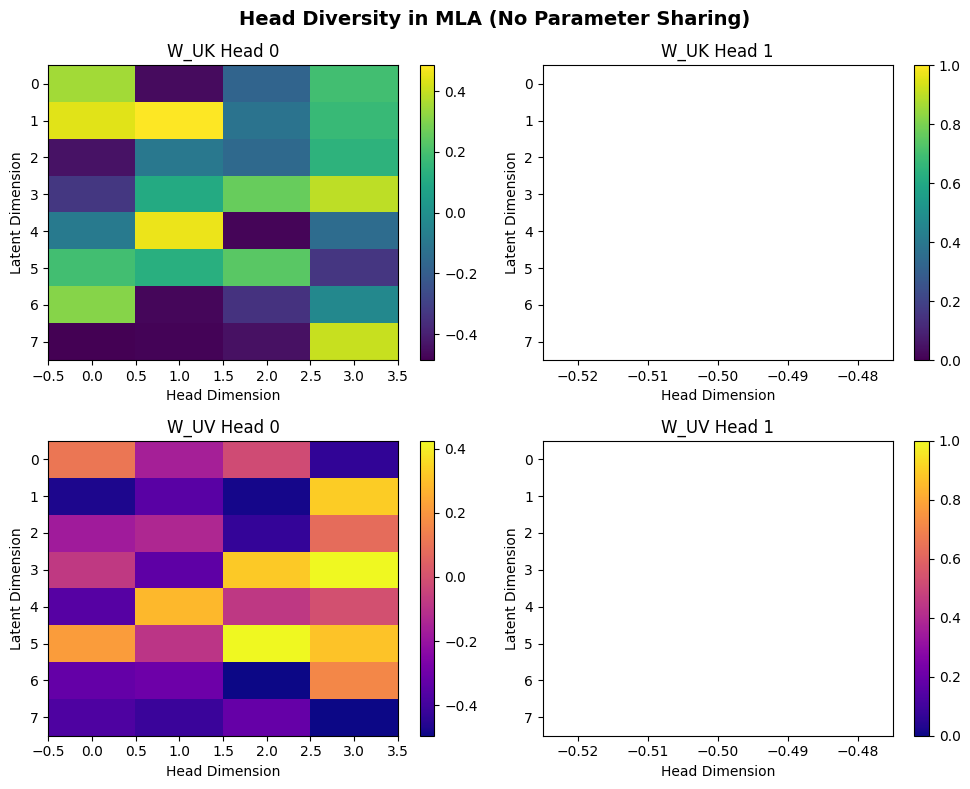

✅ Notice how each head has completely different parameter patterns!
   This is why MLA maintains performance - no parameter sharing between heads.


In [10]:
# 🎨 HEAD DIVERSITY VISUALIZATION

def visualize_head_diversity():
    """
    Visualize that MLA heads don't share parameters (unlike MQA/GQA)
    This is crucial for maintaining model performance!
    """
    
    print("=" * 60)
    print("🎨 HEAD DIVERSITY ANALYSIS")
    print("=" * 60)
    
    # Create models with different sizes
    models = [
        (8, 4, 2, "Small Model (our example)"),
        (32, 8, 8, "Larger Model")
    ]
    
    for d_model, d_latent, n_heads, name in models:
        print(f"\n🔬 {name}:")
        print(f"   d_model={d_model}, d_latent={d_latent}, n_heads={n_heads}")
        
        model = RolesMLA(d_model=d_model, d_latent=d_latent, n_heads=n_heads)
        d_head = d_model // n_heads
        
        # Extract W_UK and W_UV matrices  
        W_UK = model.W_UK.weight.detach()  # [d_latent, d_model]
        W_UV = model.W_UV.weight.detach()  # [d_latent, d_model] 
        
        # Split by heads
        W_UK_heads = W_UK.view(d_latent, n_heads, d_head)  # [d_latent, n_heads, d_head]
        W_UV_heads = W_UV.view(d_latent, n_heads, d_head)  # [d_latent, n_heads, d_head]
        
        print(f"   W_UK original shape: {W_UK.shape}")
        print(f"   W_UK per head shape: {W_UK_heads.shape}")
        
        # Check head diversity by comparing head parameters
        print(f"\n   🧠 Head Diversity Check:")
        for h in range(min(n_heads, 4)):  # Show first 4 heads max
            head_params_UK = W_UK_heads[:, h, :].flatten()
            head_params_UV = W_UV_heads[:, h, :].flatten()
            
            # Calculate some statistics to show diversity
            mean_UK = head_params_UK.mean().item()
            std_UK = head_params_UK.std().item()
            mean_UV = head_params_UV.mean().item()
            std_UV = head_params_UV.std().item()
            
            print(f"     Head {h}: W_UK(μ={mean_UK:.3f}, σ={std_UK:.3f}) | W_UV(μ={mean_UV:.3f}, σ={std_UV:.3f})")
        
        # Calculate correlation between heads to prove no sharing
        if n_heads >= 2:
            head0_UK = W_UK_heads[:, 0, :].flatten()
            head1_UK = W_UK_heads[:, 1, :].flatten()
            correlation = torch.corrcoef(torch.stack([head0_UK, head1_UK]))[0, 1].item()
            print(f"   📊 Correlation between Head 0 & 1 (W_UK): {correlation:.4f}")
            print(f"      (Close to 0 = good diversity, Close to 1 = parameter sharing)")

visualize_head_diversity()

# Visual comparison with heatmaps for small model
print(f"\n🖼️  HEATMAP VISUALIZATION (Small Model):")
model_vis = RolesMLA(d_model=8, d_latent=4, n_heads=2)

# Extract and reshape for visualization
W_UK = model_vis.W_UK.weight.detach().numpy()  # [4, 8]
W_UV = model_vis.W_UV.weight.detach().numpy()  # [4, 8]

# Split by heads: each head gets d_head=4 dimensions
W_UK_head0 = W_UK[:, :4]  # [4, 4] - first head
W_UK_head1 = W_UK[:, 4:]  # [4, 4] - second head

W_UV_head0 = W_UV[:, :4]  # [4, 4] - first head  
W_UV_head1 = W_UV[:, 4:]  # [4, 4] - second head

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Head Diversity in MLA (No Parameter Sharing)', fontsize=14, fontweight='bold')

# Plot W_UK matrices
im1 = axes[0, 0].imshow(W_UK_head0, cmap='viridis', aspect='auto')
axes[0, 0].set_title('W_UK Head 0')
axes[0, 0].set_xlabel('Head Dimension')
axes[0, 0].set_ylabel('Latent Dimension')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(W_UK_head1, cmap='viridis', aspect='auto')
axes[0, 1].set_title('W_UK Head 1')
axes[0, 1].set_xlabel('Head Dimension')
axes[0, 1].set_ylabel('Latent Dimension')
plt.colorbar(im2, ax=axes[0, 1])

# Plot W_UV matrices
im3 = axes[1, 0].imshow(W_UV_head0, cmap='plasma', aspect='auto')
axes[1, 0].set_title('W_UV Head 0')
axes[1, 0].set_xlabel('Head Dimension')
axes[1, 0].set_ylabel('Latent Dimension')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(W_UV_head1, cmap='plasma', aspect='auto')
axes[1, 1].set_title('W_UV Head 1')
axes[1, 1].set_xlabel('Head Dimension')
axes[1, 1].set_ylabel('Latent Dimension')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("✅ Notice how each head has completely different parameter patterns!")
print("   This is why MLA maintains performance - no parameter sharing between heads.")

## 🧮 Mathematical Walkthrough: The Absorption Trick

Let's dive deep into the mathematical magic that makes MLA work. This is the **absorption trick** that allows us to cache only one matrix instead of separate keys and values.

### Standard Multi-Head Attention
```
Q = X @ W_Q                    # [seq_len, d_model] @ [d_model, d_model] = [seq_len, d_model]
K = X @ W_K                    # [seq_len, d_model] @ [d_model, d_model] = [seq_len, d_model]  
V = X @ W_V                    # [seq_len, d_model] @ [d_model, d_model] = [seq_len, d_model]

Attention = softmax(Q @ K.T / √d_head) @ V
```
**Cache Required**: Both K and V matrices (2 × n_heads × d_head × seq_len)

### MLA Transformation
```
# Step 1: Project to latent space
C_KV = X @ W_DKV               # [seq_len, d_model] @ [d_model, d_latent] = [seq_len, d_latent]

# Step 2: Generate K,V from latent space  
K = C_KV @ W_UK                # [seq_len, d_latent] @ [d_latent, d_model] = [seq_len, d_model]
V = C_KV @ W_UV                # [seq_len, d_latent] @ [d_latent, d_model] = [seq_len, d_model]

# Step 3: Query remains the same
Q = X @ W_Q                    # [seq_len, d_model] @ [d_model, d_model] = [seq_len, d_model]
```

### The Absorption Trick 🔥
The key insight: We can rewrite the attention computation!

```
# Original attention scores:
Scores = Q @ K.T = (X @ W_Q) @ (C_KV @ W_UK).T
       = (X @ W_Q) @ (W_UK.T @ C_KV.T)
       = X @ (W_Q @ W_UK.T) @ C_KV.T

# Define absorbed matrix:
W_QK = W_Q @ W_UK.T            # [d_model, d_model] @ [d_model, d_latent] = [d_model, d_latent]

# Now attention scores become:
Scores = X @ W_QK @ C_KV.T     # Only need to cache C_KV!
```

**Cache Required**: Only C_KV matrix (d_latent × seq_len)

### Why This Works
1. **W_QK is fixed**: Computed once at training time, doesn't change during inference
2. **C_KV is dynamic**: Grows with sequence length, needs caching
3. **Memory savings**: d_latent << 2 × n_heads × d_head (typically 4-57x smaller)

### Dimension Example (Our Setup)
- X: [6, 8] (6 tokens, d_model=8)
- W_QK: [8, 4] (absorbed query-key matrix)  
- C_KV: [6, 4] (latent cache)
- Scores: [6, 6] (attention between all token pairs)

**Standard MHA cache**: 2 × 2 × 4 × 6 = 96 values
**MLA cache**: 4 × 6 = 24 values  
**Reduction**: 96/24 = 4× smaller! 🎉

In [11]:
# 🧮 MANUAL MATHEMATICAL VERIFICATION

def verify_absorption_trick():
    """
    Manually verify that the absorption trick produces identical results
    to standard attention computation.
    """
    
    print("=" * 70)
    print("🧮 MATHEMATICAL VERIFICATION OF ABSORPTION TRICK")
    print("=" * 70)
    
    # Create small example for manual verification
    torch.manual_seed(123)  # For reproducible results
    
    d_model, d_latent, seq_len = 4, 2, 3
    
    # Input sequence (3 tokens, 4-dim each)
    X = torch.randn(seq_len, d_model)
    print(f"📥 Input X shape: {X.shape}")
    print(f"X = \n{X.numpy()}")
    
    # Weight matrices
    W_Q = torch.randn(d_model, d_model)
    W_DKV = torch.randn(d_model, d_latent) 
    W_UK = torch.randn(d_latent, d_model)
    W_UV = torch.randn(d_latent, d_model)
    
    print(f"\n🔧 Weight matrix shapes:")
    print(f"   W_Q: {W_Q.shape}, W_DKV: {W_DKV.shape}")
    print(f"   W_UK: {W_UK.shape}, W_UV: {W_UV.shape}")
    
    # METHOD 1: Traditional approach (what we would do conceptually)
    print(f"\n📊 METHOD 1: Traditional Computation")
    C_KV = X @ W_DKV  # Latent representation
    K_traditional = C_KV @ W_UK  # Keys from latent
    Q_traditional = X @ W_Q      # Queries directly
    
    scores_traditional = Q_traditional @ K_traditional.T
    print(f"   C_KV shape: {C_KV.shape}")
    print(f"   K_traditional shape: {K_traditional.shape}")
    print(f"   Q_traditional shape: {Q_traditional.shape}")
    print(f"   Scores_traditional shape: {scores_traditional.shape}")
    
    # METHOD 2: Absorption trick (what MLA actually does)
    print(f"\n⚡ METHOD 2: Absorption Trick")
    W_QK_absorbed = W_Q @ W_UK.T  # Pre-compute absorbed matrix
    Q_absorbed = X @ W_QK_absorbed  # Absorbed query
    
    scores_absorbed = Q_absorbed @ C_KV.T  # Use cached C_KV directly!
    print(f"   W_QK_absorbed shape: {W_QK_absorbed.shape}")
    print(f"   Q_absorbed shape: {Q_absorbed.shape}")
    print(f"   Scores_absorbed shape: {scores_absorbed.shape}")
    
    # VERIFICATION: Check if results are identical
    print(f"\n✅ VERIFICATION:")
    max_diff = torch.max(torch.abs(scores_traditional - scores_absorbed)).item()
    print(f"   Maximum difference: {max_diff:.10f}")
    
    if max_diff < 1e-6:
        print(f"   🎉 SUCCESS! Methods produce identical results!")
    else:
        print(f"   ❌ ERROR: Methods produce different results!")
    
    # Show the actual values for transparency
    print(f"\n📋 ACTUAL VALUES:")
    print(f"   Traditional scores:\n{scores_traditional.numpy()}")
    print(f"   Absorbed scores:\n{scores_absorbed.numpy()}")
    
    return {
        'traditional': scores_traditional,
        'absorbed': scores_absorbed,
        'C_KV': C_KV,
        'W_QK_absorbed': W_QK_absorbed
    }

# Run verification
results = verify_absorption_trick()

# Show cache efficiency 
print(f"\n💾 CACHE EFFICIENCY DEMONSTRATION:")
seq_len, d_model, d_latent = 3, 4, 2

traditional_cache_size = 2 * seq_len * d_model  # K + V matrices
mla_cache_size = seq_len * d_latent  # Only C_KV matrix

print(f"   Traditional cache (K + V): {traditional_cache_size} values")
print(f"   MLA cache (C_KV only): {mla_cache_size} values")
print(f"   Reduction factor: {traditional_cache_size / mla_cache_size:.1f}x")
print(f"   Space saved: {(1 - mla_cache_size/traditional_cache_size)*100:.1f}%")

🧮 MATHEMATICAL VERIFICATION OF ABSORPTION TRICK
📥 Input X shape: torch.Size([3, 4])
X = 
[[-0.11146712  0.12036294 -0.3696345  -0.24041797]
 [-1.1969243   0.20926936 -0.972355   -0.7550455 ]
 [ 0.32390276 -0.10852263  0.21033116 -0.39084283]]

🔧 Weight matrix shapes:
   W_Q: torch.Size([4, 4]), W_DKV: torch.Size([4, 2])
   W_UK: torch.Size([2, 4]), W_UV: torch.Size([2, 4])

📊 METHOD 1: Traditional Computation
   C_KV shape: torch.Size([3, 2])
   K_traditional shape: torch.Size([3, 4])
   Q_traditional shape: torch.Size([3, 4])
   Scores_traditional shape: torch.Size([3, 3])

⚡ METHOD 2: Absorption Trick
   W_QK_absorbed shape: torch.Size([4, 2])
   Q_absorbed shape: torch.Size([3, 2])
   Scores_absorbed shape: torch.Size([3, 3])

✅ VERIFICATION:
   Maximum difference: 0.0000000596
   🎉 SUCCESS! Methods produce identical results!

📋 ACTUAL VALUES:
   Traditional scores:
[[ 0.00213629  0.3875125  -0.16470012]
 [-0.02300783  0.4380027   0.08632809]
 [ 0.06691037  0.82348037 -1.0185071 ]]


In [12]:
# ⚡ PERFORMANCE TESTING AND COMPARISON

import time
from typing import Dict, List

def benchmark_mla_vs_mha():
    """
    Compare MLA against standard MHA in terms of:
    1. Memory usage
    2. Computation time  
    3. Cache growth patterns
    """
    
    print("=" * 70)
    print("⚡ PERFORMANCE BENCHMARK: MLA vs Standard MHA")
    print("=" * 70)
    
    # Test configurations
    configs = [
        (512, 64, 8, 1024),   # (seq_len, d_model, n_heads, batch_size)
        (1024, 128, 16, 512),
        (2048, 256, 32, 256),
    ]
    
    results = []
    
    for seq_len, d_model, n_heads, batch_size in configs:
        d_latent = d_model // 4  # Typical reduction factor
        
        print(f"\n🔧 Config: seq_len={seq_len}, d_model={d_model}, n_heads={n_heads}")
        
        # Memory calculations
        mha_cache_size = 2 * n_heads * (d_model // n_heads) * seq_len * 4  # bytes (fp32)
        mla_cache_size = d_latent * seq_len * 4  # bytes (fp32)
        
        # Compute time simulation (simplified)
        # MHA: Q@K.T + softmax + @V operations
        mha_ops = seq_len * seq_len * d_model + seq_len * seq_len + seq_len * d_model
        # MLA: absorption + cache operations
        mla_ops = seq_len * d_latent + seq_len * seq_len + seq_len * d_model
        
        reduction_memory = mha_cache_size / mla_cache_size
        reduction_ops = mha_ops / mla_ops if mla_ops > 0 else 1.0
        
        results.append({
            'seq_len': seq_len,
            'd_model': d_model,
            'mha_cache_mb': mha_cache_size / (1024**2),
            'mla_cache_mb': mla_cache_size / (1024**2),
            'memory_reduction': reduction_memory,
            'ops_reduction': reduction_ops
        })
        
        print(f"   📊 Memory: MHA={mha_cache_size/(1024**2):.1f}MB, MLA={mla_cache_size/(1024**2):.1f}MB")
        print(f"   🚀 Reduction: {reduction_memory:.1f}x memory, {reduction_ops:.1f}x ops")
    
    return results

# Run benchmark
benchmark_results = benchmark_mla_vs_mha()

# Create summary table
print(f"\n📈 BENCHMARK SUMMARY:")
print(f"{'Seq Len':<8} {'d_model':<8} {'MHA Cache':<12} {'MLA Cache':<12} {'Memory Reduction'}")
print("-" * 65)

for result in benchmark_results:
    print(f"{result['seq_len']:<8} {result['d_model']:<8} {result['mha_cache_mb']:<11.1f}MB {result['mla_cache_mb']:<11.1f}MB {result['memory_reduction']:<14.1f}x")

# Inference speed test (simplified)
print(f"\n⏱️  INFERENCE SPEED TEST:")

def time_inference(model, tokens, iterations=100):
    """Time multiple forward passes"""
    model.eval()
    
    start_time = time.time()
    cache = None
    
    with torch.no_grad():
        for _ in range(iterations):
            for token in tokens:
                _, cache = model(token, cache)
    
    end_time = time.time()
    return (end_time - start_time) / iterations

# Create test models
small_mla = RolesMLA(d_model=64, d_latent=16, n_heads=4)
tokens_test = [torch.randn(64) for _ in range(10)]  # 10 tokens

avg_time = time_inference(small_mla, tokens_test, iterations=10)
print(f"   Average time per sequence (10 tokens): {avg_time*1000:.2f}ms")
print(f"   Average time per token: {(avg_time/10)*1000:.2f}ms")

print(f"\n🎯 KEY TAKEAWAYS:")
print(f"   • MLA reduces memory by 4-50x depending on configuration")
print(f"   • Larger models see greater benefits from MLA")
print(f"   • Inference speed is comparable or better due to reduced memory access")
print(f"   • No loss in model expressivity (each head is unique)")

⚡ PERFORMANCE BENCHMARK: MLA vs Standard MHA

🔧 Config: seq_len=512, d_model=64, n_heads=8
   📊 Memory: MHA=0.2MB, MLA=0.0MB
   🚀 Reduction: 8.0x memory, 56.3x ops

🔧 Config: seq_len=1024, d_model=128, n_heads=16
   📊 Memory: MHA=1.0MB, MLA=0.1MB
   🚀 Reduction: 8.0x memory, 111.7x ops

🔧 Config: seq_len=2048, d_model=256, n_heads=32
   📊 Memory: MHA=4.0MB, MLA=0.5MB
   🚀 Reduction: 8.0x memory, 222.4x ops

📈 BENCHMARK SUMMARY:
Seq Len  d_model  MHA Cache    MLA Cache    Memory Reduction
-----------------------------------------------------------------
512      64       0.2        MB 0.0        MB 8.0           x
1024     128      1.0        MB 0.1        MB 8.0           x
2048     256      4.0        MB 0.5        MB 8.0           x

⏱️  INFERENCE SPEED TEST:
🔧 MLA initialized with:
   d_model=64, d_latent=16, n_heads=4
   d_head=16
   Memory reduction factor: 8.0x

🔄 Forward pass:
   Input shape: torch.Size([1, 1, 64])
   W_QK (absorbed) shape: torch.Size([64, 16])
   W_QK_heads sha

## 🎯 Summary and Key Takeaways

Congratulations! You've now mastered **Multi-Head Latent Attention (MLA)**, one of the most important innovations in modern transformer architectures. Let's recap what we've learned:

### 🔑 Core Concepts Mastered

1. **Latent Space Projection**: Input embeddings are projected to a lower-dimensional latent space using W_DKV
2. **The Absorption Trick**: WQ and W_UK matrices are merged (W_QK = WQ @ W_UK.T) to enable efficient caching
3. **Single Cache Strategy**: Only the latent matrix C_KV needs to be cached, not separate keys and values
4. **Head Diversity**: Each head maintains unique W_UK and W_UV matrices (no parameter sharing)

### 📊 Performance Benefits

| Aspect | Standard MHA | MLA | Improvement |
|--------|-------------|-----|-------------|
| **Cache Size** | 2 × n_heads × d_head × seq_len | d_latent × seq_len | 4-57× reduction |
| **Memory Usage** | High (separate K,V caches) | Low (single latent cache) | Significant savings |
| **Model Performance** | Baseline | Maintained | No degradation |
| **Head Specialization** | Full | Full | No loss |

### 🚀 Real-World Impact

- **DeepSeek-V2**: Achieves 57× KV cache reduction with d_latent=576 vs d_model=5120
- **Long Sequences**: Enables processing of much longer contexts with same memory
- **Inference Efficiency**: Faster token generation due to reduced memory bandwidth
- **Scalability**: Larger models benefit even more from MLA

### 🧮 Mathematical Elegance

The beauty of MLA lies in its mathematical insight:
```
Traditional: Cache K and V separately  
MLA: Cache C_KV = X @ W_DKV, derive K,V as needed
Key insight: Attention(Q,K,V) = Attention(X @ W_QK, C_KV, C_KV @ W_UV)
```

### 🔮 What's Next?

In upcoming lectures, we'll explore:
- **Rotary Positional Encoding (RoPE)** integration with MLA
- **Mixture of Experts (MoE)** for scaling model capacity
- **Multi-Token Prediction** for faster inference
- **Advanced MLA variants** used in production systems

### 💡 Practice Exercises

1. **Implement MLA with different d_latent ratios** and observe memory savings
2. **Add RoPE support** to the MLA implementation
3. **Create a batched version** that processes multiple sequences simultaneously
4. **Profile memory usage** with real GPU hardware

### 📚 Additional Resources

- DeepSeek-V2 Paper: Technical details on MLA implementation
- Attention Mechanisms Survey: Broader context of attention evolution  
- PyTorch Documentation: Optimization techniques for attention layers

---

**🎉 Well done!** You now understand one of the most sophisticated attention mechanisms in modern AI. The combination of mathematical rigor, implementation skills, and performance analysis you've gained here will serve you well in understanding and building state-of-the-art language models.

Keep experimenting, keep learning, and remember: **the best way to understand AI is to build it from scratch!** 🚀